### TP2 : La chasse au papyrus

  Internet regorge de bases de données intéressantes, surtout pour les linguistes et les humanités numériques. En effet, ils mettent souvent en ligne des bases de données spécialisées permettant (gratuitement ou non) d'explorer une collection particulière. Si la base de donnée est hébergée sur le site et naviguable, on ne peut malheureusement pas en faire une exploration quantitative puisque les sites n'offrent pas l'option de télécharger l'ensemble des données. De plus on est pas forcément intéressé par toute la collection ni par toutes les métadonnées disponibles pour chaque document.


Heureusement, python est là pour nous aider !



L'objectif de ce TP est de collecter, stocker et analyser une collection de papyri grecs. Ce sera l'occasion de voir comment on peut utiliser les librairies de data science actuelles pour observer et analyser un dataset original

**Objectifs :**

1) Réviser les techniques de web scraping pour voir comment collecter un dataset:
* déduire la structure des url à regarder
* télécharger les pages HTML
* regarder la structure de la page et utiliser un parser HTML pour extraire les données

2) stocker les données sous un format csv. Utiliser pandas pour les analyser

3) construire des visualisations intéressantes du dataset

4) gérer le texte grec, son encodage, les outils TAL pour le traiter

5) utiliser streamlit, une librairie intuitive pour créer un front permettant d'explorer la collection de papyri.


Le rendu prendra la forme d'une archive contenant 3 fichiers .py ainsi qu'un fichier requirements.txt

# I) Web scraping et collecte de la base de données des papyrus. /6

L'objectif de ce TP est d'analyser une collection de papyri grecs particulière.

Nous nous intéresserons à une partie de la collection préservée sur le site trismegistos.

https://www.trismegistos.org/

Nous ne nous intéresserong qu'à un nombre limité de papyri dont la liste est fournie en annexe (fichier papyrus_metadata.csv)



# 1) Collecte des URL

 A partir de la liste des papyri à étudier, générez la liste des url à crawler. Pour cela parcourez le site pour comprendre la structure des url donnant accès à un papyrus.

# **Scraping**

La fonction `scrap_papyrus()` retourne un JSON contenant les informations suivantes sur le papyrus:</br>

✅ Language</br>
✅ Content</br>
✅ Date</br>
✅ Provenance</br>
✅ Material</br>
✅ Archive</br>
✅ Collections</br>
✅ Publications</br>
✅ Le texte grec formaté</br>
✅ La liste des noms de personnes</br>
✅ La liste des noms de lieux</br>
✅ La liste des irrégularités textuelles</br>

Plus précisément :
```python
            item_data = {
                "Language": None,
                "Content": None,
                "Date": None,
                "Provenance": None,
                "Material": None,
                "Archive": [],
                "Collections": [],
                "Publications": [],
                "GreekText": None,
                "People": [],
                "Places": [],
                "Irregularities": []
            }
```



In [1]:
!wget https://raw.githubusercontent.com/Dinarque/INALCO_Techniques_web_en_python_2025/refs/heads/main/TP/papyrus_corpus.csv -q

### **Pipeline de nettoyage**

[<img src="https://img.icons8.com/material-outlined/24/000000/download--v1.png"/> **Téléchargez le fichier py pour faire le scrapping**](https://raw.githubusercontent.com/GwenTsang/Papyri/refs/heads/main/scrapping/scrapapyrus.py)


[<img src="https://img.icons8.com/material-outlined/24/000000/download--v1.png"/> **Téléchargez le JSON contenant les métadonnées de 10 pages scrappées**](https://github.com/GwenTsang/Papyri/blob/main/data/trismegistos_data_papyrus_1-10-full.json)


# II) Analyse du dataset



Dans cette partie, nous allons utiliser les librairies de datascience pour visualiser, analyser et enrichir le corpus que nous avons scrapé

#### **Détails sur le nettoyage**


Toutes les étapes de nettoyage sont centralisées dans le code python qui suit.

On retire :

- les chiffres arabes (qui indiquaient vraissemblablement les numéros des lignes),
- les " | gap | " qui indiquent des lignes perdues,
- les caractères spéciaux "†" et "⳨".


```python

df["Full Text"] = (df["Full Text"]
    .str.replace(r"\d+", "", regex=True)
    .str.replace(r"\| gap \|", "", regex=True)
    .str.replace(r"[†⳨]", "", regex=True)
)

```


On utilise une regex

```python

uncertain_chars = re.findall(r'\[.*?\]|\(.*?\)', text)

```

Notons que les parenthèses correspondent à du texte perdu et reconstruit tandis que les parenthèses correspondent à du texte qui a été abrégé.
</br>

Si on souhaitait distinguer l'un et l'autre, on peut utiliser :
```python

matches = re.compile(r"\[(.*?)\]|\((.*?)\)").findall(text)

```
qui permet une distinction entre les strings qui se trouvaient entre parenthèses et celles qui se trouvaient entre crochets. Mais ici on **supprime** toutes les parenthèses et tous les crochets.


Voici la signification de certains codes en papyrologie :

 - Les petits points en dessous de certaines lettres indiquent que la lettre est défformée ou difficilement lisible,

On les retire. Mais il semble que ça diminue un peu (bizarement) les performances du NER

In [2]:
import pandas as pd
import numpy as np
import re
import ast
import unicodedata

class PapyrusCleaner:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
        # Regex pour le grec ancien et étendu
        # \u0370-\u03FF : Grec et Copte
        # \u1F00-\u1FFF : Grec étendu (polytonique)
        # \u0300-\u036F : Diacritiques combinants
        self.greek_regex = r"[\u0370-\u03FF\u1F00-\u1FFF\u0300-\u036F]"

    def _normalize_greek(self, text):
        """
        Normalisation standard : minuscule, suppression des diacritiques,
        et normalisation du sigma final.
        """
        if not isinstance(text, str):
            return ""

        # Minuscule
        text = text.lower()

        # Décomposition NFD pour séparer les accents des lettres
        text = unicodedata.normalize("NFD", text)

        # On garde les caractères qui ne sont pas des marques de non-espacement (Mn)
        # Sauf si on veut garder l'esprit rude/doux
        text = "".join(c for c in text if unicodedata.category(c) != "Mn")

        # Recomposition NFC
        text = unicodedata.normalize("NFC", text)

        # Normalisation du sigma final (ς -> σ) pour faciliter les comparaisons
        text = text.replace("ς", "σ")

        return text

    def _parse_list_column(self, text):
        """Transforme les chaînes "['a', 'b']" en listes python."""
        try:
            # ast.literal_eval est plus sûr que eval()
            val = ast.literal_eval(str(text))
            if isinstance(val, list):
                # On nettoie chaque élément de la liste
                return [self._normalize_greek(x) for x in val if isinstance(x, str)]
            return []
        except (ValueError, SyntaxError):
            return []

    def filter_valid_rows(self):
        """Étape 1: Filtre les lignes sans texte ou sans caractères grecs."""
        print("--- Filtrage des lignes invalides ---")
        initial_len = len(self.df)

        # Pas de NaN et pas la chaine littérale "nan"
        valid_text = (
            self.df["Full Text"].notna() &
            (self.df["Full Text"].astype(str).str.strip() != "") &
            ~self.df["Full Text"].astype(str).str.lower().str.contains("nan", regex=False)
        )

        # Doit contenir du grec
        has_greek = self.df["Full Text"].astype(str).str.contains(self.greek_regex, regex=True, na=False)

        self.df = self.df[valid_text & has_greek]
        print(f"Lignes supprimées : {initial_len - len(self.df)}")
        return self

    def clean_full_text_content(self):
        """Étape 2: Nettoyage spécifique du contenu (chiffres, gaps, symboles)."""
        print("Nettoyage du corps du texte (Full Text)")

        def cleaner(text):
            if not isinstance(text, str): return ""
            # Enlever les chiffres (numéros de lignes)
            text = re.sub(r"\d+", "", text)
            # Enlever les marqueurs de lacunes
            text = re.sub(r"\| gap \|", "", text)
            # Enlever les croix et symboles chrétiens
            text = re.sub(r"[†⳨]", "", text)
            # Enlever les espaces multiples
            text = re.sub(r"\s+", " ", text).strip()
            return text

        self.df["Full Text Cleaned"] = self.df["Full Text"].apply(cleaner)
        # On crée aussi une version normalisée (sans accents) pour l'analyse
        self.df["Full Text Normalized"] = self.df["Full Text Cleaned"].apply(self._normalize_greek)
        return self

    def process_metadata_lists(self):
        """Étape 3: Traitement des colonnes listes (People, Places)."""
        print("Traitement des métadonnées (People & Places)")
        cols_to_fix = ["People List", "Places List"]

        for col in cols_to_fix:
            if col in self.df.columns:
                # On parse la string pour en faire une liste, et on normalise le grec dedans
                self.df[f"{col} Processed"] = self.df[col].apply(self._parse_list_column)
        return self

    def format_dates(self):
        """Étape 4: Extraction et nettoyage des dates."""
        print("--- Formatage des dates ---")

        def clean_date(text):
            if not isinstance(text, str): return None
            # On prend ce qui est après le dernier ":" (format fréquent dans ce dataset)
            parts = text.split(":")[-1].strip()
            # Regex simple pour capturer AD XXX - XXX ou AD XXX
            match = re.search(r'(AD|BC)\s*(\d+)(?:\s*-\s*(\d+))?', parts)
            if match:
                era = match.group(1)
                start = match.group(2)
                end = match.group(3)
                if end:
                    return f"{era} {start} - {end}"
                return f"{era} {start}"
            return parts

        self.df["Date Cleaned"] = self.df["Date"].apply(clean_date)
        return self

    def compute_uncertainty(self):
        """Étape 5: Calcul du taux d'incertitude (lettres entre crochets/parenthèses)."""
        print("--- Calcul de l'incertitude ---")

        def calculate_ratio(text):
            if not isinstance(text, str): return 0.0
            # Trouve tout ce qui est entre [] ou ()
            matches = re.findall(r"\[[^\]]*?\]|\([^\)]*?\)", text)
            # Longueur du texte incertain (moins les délimiteurs)
            uncertain_len = sum(len(m) - 2 for m in matches)
            # Longueur totale (moins les délimiteurs présents dans le texte)
            total_len = len(text) - text.count('[') - text.count(']') - text.count('(') - text.count(')')

            if total_len == 0: return 0.0
            return uncertain_len / total_len

        self.df["Uncertainty Ratio"] = self.df["Full Text Cleaned"].apply(calculate_ratio)
        return self

    def clean_irregularities(self):
        """Étape 6: Nettoyage de la colonne des fautes (pour l'analyse sonore)."""
        print("--- Nettoyage des irrégularités textuelles ---")

        def parse_irregularities(text):
            # Parse la liste stringifiée
            try:
                items = ast.literal_eval(str(text))
                if not isinstance(items, list): return []
            except:
                return []

            cleaned_items = []
            for item in items:
                if isinstance(item, str) and ': read ' in item:
                    # On normalise les deux parties (Old : read New)
                    parts = item.split(': read ')
                    if len(parts) == 2:
                        cleaned_items.append(f"{self._normalize_greek(parts[0])} : read {self._normalize_greek(parts[1])}")
            return cleaned_items

        self.df["Irregularities Processed"] = self.df["Text Irregularities"].apply(parse_irregularities)
        return self

    def get_dataframe(self):
        """Retourne le dataframe nettoyé."""
        return self.df

# Chargement
df_raw = pd.read_csv("/content/papyrus_corpus.csv")

# Pipeline
pipeline = PapyrusCleaner(df_raw)
df_clean = (pipeline
            .filter_valid_rows()
            .clean_full_text_content()
            .format_dates()
            .process_metadata_lists()
            .compute_uncertainty()
            .clean_irregularities()
            .get_dataframe()
           )

# Sauvegarde finale unique
df_clean.to_csv("/content/papyrus_corpus_cleaned.csv", index=False)
print("Pipeline terminé. Dataset prêt.")
df_clean.head()

--- Filtrage des lignes invalides ---
Lignes supprimées : 123
Nettoyage du corps du texte (Full Text)
--- Formatage des dates ---
Traitement des métadonnées (People & Places)
--- Calcul de l'incertitude ---
--- Nettoyage des irrégularités textuelles ---
Pipeline terminé. Dataset prêt.


,ID,Authors / works,Book form,Content (beta!),Culture & genre,Date,Full Text,Language/script,Material,Note,...,Reuse type,Ro,Text Irregularities,Full Text Cleaned,Full Text Normalized,Date Cleaned,People List Processed,Places List Processed,Uncertainty Ratio,Irregularities Processed
4,TM 19028,NaN,NaN,Contract: sale,NaN,AD 490 - 565,1 [--------------------] [.....] [Διοσκ]ό̣ρο...,Greek,NaN,NaN,...,NaN,NaN,['καθ’: read κατʼ'],[--------------------] [.....] [Διοσκ]ό̣ρου̣ ε...,[--------------------] [.....] [διοσκ]ορου ε[-...,AD 490 - 565,"[ 1διοσκορου, subscribe to export the table]",[],0.495394,[καθ’ : read κατʼ]
5,TM 19001,NaN,NaN,Receipt,NaN,AD 507 Mar 21?AD 492 Mar 21?,1 [⳨] δ̣[έ]δ̣[ω]κ̣[εν] Διόσκορ[ος] [Ψ]ιμανω...,Greek,NaN,NaN,...,NaN,NaN,['σεμημείωμαι: read σεσημείωμαι'],[] δ̣[έ]δ̣[ω]κ̣[εν] Διόσκορ[ος] [Ψ]ιμανωβετ δ(...,[] δ[ε]δ[ω]κ[εν] διοσκορ[οσ] [ψ]ιμανωβετ δ(ια)...,AD 507,"[ 1διοσκοροσ, ψιμανωβετ, subscribe to export t...",[],0.322835,[σεμημειωμαι : read σεσημειωμαι]
6,TM 45294,NaN,NaN,Receipt,NaN,6th century AD: AD 500 - 599,1 † τὸ δίκα[ι]ον τοῦ ἁγίου τόπου ἄπα Μ̣...,Greek,NaN,NaN,...,NaN,NaN,[],τὸ δίκα[ι]ον τοῦ ἁγίου τόπου ἄπα Μ̣ιχα̣η̣λί̣ο̣...,το δικα[ι]ον του αγιου τοπου απα μιχαηλιου [δι...,AD 500 - 599,"[ 1αραουτοσ, 2φοιβαμμωνι, τριαδελφου, 7αραου...",[],0.463074,[]
7,TM 38431,NaN,NaN,List,NaN,6th century AD: AD 500 - 599,1 χμγ 2 |̣ṣṭạụṛọṣ|̣ ἀ̣ρ̣ι̣θ̣μηθέντα ε...,Greek,NaN,NaN,...,NaN,NaN,['νταρίου: read ν<ο>ταρίου'],χμγ |̣ṣṭạụṛọṣ|̣ ἀ̣ρ̣ι̣θ̣μηθέντα εἰς τὸν...,χμγ |stauros| αριθμηθεντα εισ τον λογον αμμωνι...,AD 500 - 599,"[ 3αμμωνιανοσ, διονυσοδωρου, 4παιοσ, θεωνοσ, ...",[],0.299685,[νταριου : read ν<ο>ταριου]
8,TM 38430,NaN,NaN,List,NaN,6th century AD: AD 500 - 599,1 † γνῶσ(ις) ὀνομ(άτων) 2 οὕ(τως) · 3 μ̣εμε...,Greek,NaN,NaN,...,NaN,NaN,['Κώμα: read Κόμα'],γνῶσ(ις) ὀνομ(άτων) οὕ(τως) · μ̣εμερίκ̣(αμεν) ...,γνωσ(ισ) ονομ(ατων) ου(τωσ) · μεμερικ(αμεν) απ...,AD 500 - 599,"[ 5πουωνσ, 7φιλοξενον, subscribe to export th...",[],0.195402,[κωμα : read κομα]


Dans ce qui suit, on utilisera deux DataFrames distincts :


In [3]:
df_raw = pd.read_csv("papyrus_corpus.csv")
df_clean = pd.read_csv("papyrus_corpus_cleaned.csv")

* Afficher les 4 premières lignes

In [4]:
df_clean.head(4)

,ID,Authors / works,Book form,Content (beta!),Culture & genre,Date,Full Text,Language/script,Material,Note,...,Reuse type,Ro,Text Irregularities,Full Text Cleaned,Full Text Normalized,Date Cleaned,People List Processed,Places List Processed,Uncertainty Ratio,Irregularities Processed
0,TM 19028,NaN,NaN,Contract: sale,NaN,AD 490 - 565,1 [--------------------] [.....] [Διοσκ]ό̣ρο...,Greek,NaN,NaN,...,NaN,NaN,['καθ’: read κατʼ'],[--------------------] [.....] [Διοσκ]ό̣ρου̣ ε...,[--------------------] [.....] [διοσκ]ορου ε[-...,AD 490 - 565,"[' 1διοσκορου', 'subscribe to export the table']",[],0.495394,['καθ’ : read κατʼ']
1,TM 19001,NaN,NaN,Receipt,NaN,AD 507 Mar 21?AD 492 Mar 21?,1 [⳨] δ̣[έ]δ̣[ω]κ̣[εν] Διόσκορ[ος] [Ψ]ιμανω...,Greek,NaN,NaN,...,NaN,NaN,['σεμημείωμαι: read σεσημείωμαι'],[] δ̣[έ]δ̣[ω]κ̣[εν] Διόσκορ[ος] [Ψ]ιμανωβετ δ(...,[] δ[ε]δ[ω]κ[εν] διοσκορ[οσ] [ψ]ιμανωβετ δ(ια)...,AD 507,"[' 1διοσκοροσ', 'ψιμανωβετ', 'subscribe to exp...",[],0.322835,['σεμημειωμαι : read σεσημειωμαι']
2,TM 45294,NaN,NaN,Receipt,NaN,6th century AD: AD 500 - 599,1 † τὸ δίκα[ι]ον τοῦ ἁγίου τόπου ἄπα Μ̣...,Greek,NaN,NaN,...,NaN,NaN,[],τὸ δίκα[ι]ον τοῦ ἁγίου τόπου ἄπα Μ̣ιχα̣η̣λί̣ο̣...,το δικα[ι]ον του αγιου τοπου απα μιχαηλιου [δι...,AD 500 - 599,"[' 1αραουτοσ', ' 2φοιβαμμωνι', 'τριαδελφου', '...",[],0.463074,[]
3,TM 38431,NaN,NaN,List,NaN,6th century AD: AD 500 - 599,1 χμγ 2 |̣ṣṭạụṛọṣ|̣ ἀ̣ρ̣ι̣θ̣μηθέντα ε...,Greek,NaN,NaN,...,NaN,NaN,['νταρίου: read ν<ο>ταρίου'],χμγ |̣ṣṭạụṛọṣ|̣ ἀ̣ρ̣ι̣θ̣μηθέντα εἰς τὸν...,χμγ |stauros| αριθμηθεντα εισ τον λογον αμμωνι...,AD 500 - 599,"[' 3αμμωνιανοσ', 'διονυσοδωρου', ' 4παιοσ', 'θ...",[],0.299685,['νταριου : read ν<ο>ταριου']


* **Combien de textes n'ont pas été capturés pendant le scraping ?**


In [5]:
# Compter le nombre de cellules contenant "nan" dans la colonne 'Full Text'

# Pour compter les vraies valeurs manquantes (NaN) :
count_nan = df_raw["Full Text"].isna().sum()

print(f"Nombre de cellules manquantes dans la colonne 'Full Text': {count_nan}")
print(f"Si on les enlève, il restera {len(df_raw) - count_nan} papyri clean")

Nombre de cellules manquantes dans la colonne 'Full Text': 120
Si on les enlève, il restera 459 papyri clean



* **Trier la collection selon l'ID (ordre croissant)**

In [6]:
import pandas as pd

# Sorting the DataFrame
df_clean = df_clean.sort_values(
    by="ID",
    key=lambda x: x.str.replace("TM ", "", regex=False).astype(int)
)

# 5) Etude de corpus : genre, lieu et date



**Quelles sont les différents genre de texte que l'on a collecté ?**

In [7]:
genres_uniques = df_clean["Content (beta!)"].unique()
print(genres_uniques)

['Petition' 'Contract: loan' 'Receipt: taxes' 'Contract: lease'
 'Contract: surety' 'Other: fragment' 'Receipt' 'Contract'
 'Letter: official' 'Bond' 'Judicial: edict'
 'PetitionSee also TM Letters TOP SS6 (1formula).'
 'LetterSee also TM Letters TOP SS6 (1formula).' 'Contract: sale'
 'PetitionSee also TM Letters TOP SS6 (3formulae).'
 'Letter: officialSee also TM Letters TOP SS6 (2formulae).'
 'Receipt: debt' 'Contract: marriage / divorce' 'Contract: testament'
 'Contract: division' 'List' 'Receipt: order' 'Administration: register'
 'Account' 'Account: private' 'Contract: donation' 'Judicial: protocol'
 'Record' 'Letter' 'End of a ekmarturion'
 'LetterSee also TM Letters TOP SS6 (2formulae).'
 'PetitionSee also TM Letters TOP SS6 (2formulae).' 'Receipt: payment'
 'Letter: payment order'
 'Receipt: orderSee also TM Letters TOP SS6 (1formula).'
 'LetterSee also TM Letters TOP SS6 (3formulae).'
 'report legal proceedings (inheritance dispute)'
 'Delivery of wheat and meat for the army' 

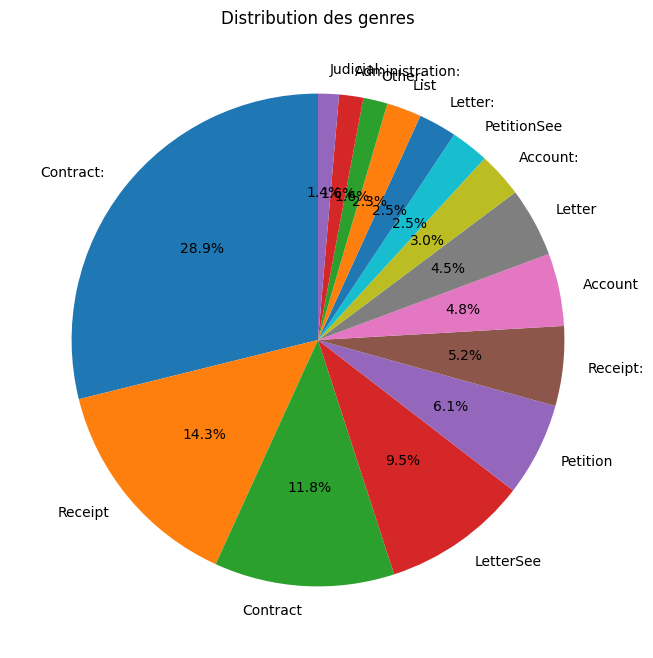

In [8]:
import pandas as pd
from matplotlib.pyplot import subplots
from matplotlib.pyplot import show


# Enlever les valeurs NaN values et spliter en espace pour récupérer le premier mot
first_words = df_clean["Content (beta!)"].dropna().str.split().str[0]

# Compter les occurences de chaque mot
word_counts = first_words.value_counts()

# Limitation à 10 catégories (en supprimant les autres dans le calcul)
word_counts = word_counts.head(15)

# Création du pie chart
fig, ax = subplots(figsize=(10, 8))
ax.pie(word_counts.values, labels=word_counts.index, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution des genres')

# Affichage du chart
show()

* **D'où viennent les papyri ?  De même ne retenez que le nom de la ville. Faites un diagramme en barre .**

In [9]:
# Inspecter le contenu de la colonne "Provenance" sous forme de liste

print(df_clean["Provenance"].dropna().str.split().str[0].to_list())

['Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Byzantion', 'Aphrodito', 'Antaiopolis', 'Antaiopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Byzantion', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Antinoopolis', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Byzantion', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodito', 'Aphrodit

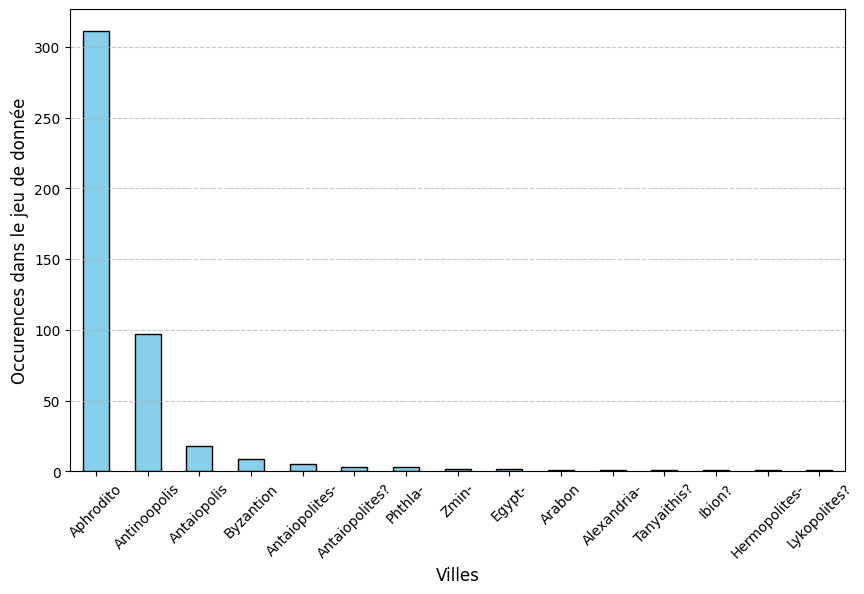

In [10]:
import matplotlib.pyplot as plt

cities = df_clean["Provenance"].dropna().str.split().str[0]

city_counts = cities.value_counts()

plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Villes', fontsize=12)
plt.ylabel('Occurences dans le jeu de donnée', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Réponse** : La majorité des papyri proviennent d'Aphrodito

In [11]:
# Inspecter le contenu de la colonne "Date"
print(df_clean["Date"].head(10).to_string(index=False))

                                      aboutAD 565?
                                    AD 566 Feb 22?
                                    AD 531 May 22?
year 26 of Iustinianus: AD 551 Aug 30 - 552 Aug 28
 year 5 of Iustinus II: AD 569 Aug 29 - 570 Aug 28
                                      AD 524 Oct 6
                                      AD 518 - 527
epagomenal days: AD 538 Aug 24 - 28Mesore Epago...
year 13 of Iustinianus ?: AD 538 Aug 29 - 539 A...
 year 9 of Iustinianus: AD 534 Aug 29 - 535 Aug 29




* **Formattez les dates sous le format d'une date simple AD xxx ou d'un intervalle AD xxx - xxx**




En python, `range` ne définit pas un intervalle continu, mais une suite discrète de valeurs entières.

Mais il faut obtenir un graphique qui “semble continu". Pour cela, on utilise `sns.kdeplot` qui permet de donner une ***estimation lisse*** de la distribution.

In [12]:
import seaborn as sns
import re

def extract_years(date_str: str):
    """Extraire les années sous forme de plage, en traitant à la fois les dates après et avant J.-C."""
    match_range_ad = re.search(r'AD (\d+)\s*-\s*(\d+)', date_str) # AC = After Christ, après l'an 0
    match_single_ad = re.search(r'AD (\d+)', date_str)
    match_range_bc = re.search(r'BC (\d+)\s*-\s*(\d+)', date_str) # BC = Before Christ, avant l'an 0
    match_single_bc = re.search(r'BC (\d+)', date_str)

    if match_range_ad:
        return range(int(match_range_ad.group(1)), int(match_range_ad.group(2)) + 1)
    elif match_single_ad:
        year = int(match_single_ad.group(1))
        return range(year, year + 1)
    elif match_range_bc:
        return range(-int(match_range_bc.group(1)), -int(match_range_bc.group(2)) - 1, -1)
    elif match_single_bc:
        year = -int(match_single_bc.group(1))
        return range(year, year + 1)

    return


def cleaned_date(date_text: str) -> str:
    """Formattage des dates"""
    match = re.search(r'(AD|BC)\s*(\d+)(?:\s*[A-Za-z]+\s*\d*)?\s*-\s*(\d+)', date_text)
    if match:
        era, start_year, end_year = match.groups()
        return f"{era} {start_year} - {end_year}"

    match_single = re.search(r'(AD|BC)\s*(\d+)', date_text)
    if match_single:
        era, year = match_single.groups()
        return f"{era} {year}"

    return date_text

def extract_date(text: str) -> str:
    """Extract the date information from the text."""
    return text.split(":")[-1].strip()

def date_analysis(df: pd.DataFrame):
    """Analyser les dates et afficher un graphique de densité des papyrus au fil du temps."""
    df['Date'] = df['Date'].apply(extract_date).apply(cleaned_date)
    years = []
    for date in df['Date'].dropna():
        year_range = extract_years(date)
        if year_range:
            years.extend(year_range)

    # Générer le graphique de densité
    plt.figure(figsize=(10, 5))
    # Ici un appel à un kernel density estimator qui permet un "lissage"
    sns.kdeplot(years, fill=True)
    plt.title("Density of Papyrus per Years")
    plt.xlabel("Years")
    plt.ylabel("Density")
    plt.xlim(min(years), max(years))
    plt.grid()
    plt.show()

* **Construire un diagramme représentant la densité de papyri sur chaque année du dataset. Quand il y a plusieurs dates mentionnées dans la colonne, ne prendre en compte que la première**


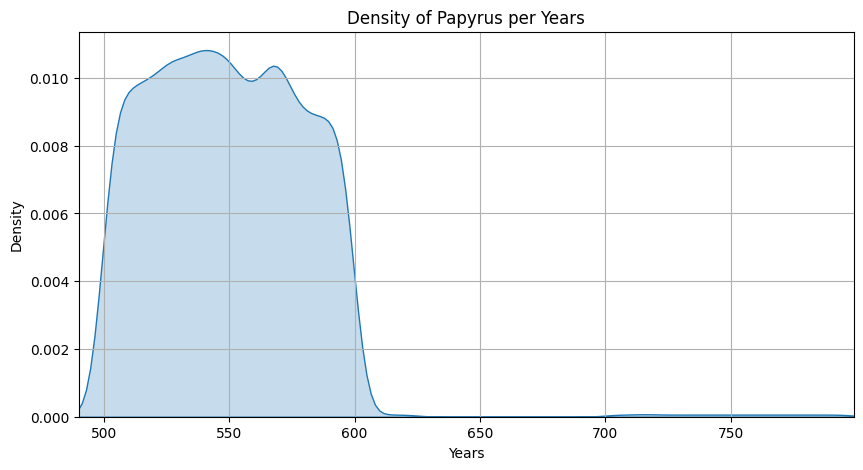

In [13]:
date_analysis(df_clean)

Pour enlever les chiffres arabes on utilise `\d` qui correspond à un entier (0, 1, ..., 9)


**Combien y a-t de papyrus dont plus du tiers du texte est incertain ?**

In [14]:
count_more_than_third = int((df_clean["Uncertain Portion"] > (1/3)).sum())
print(f"Nombre de papyrus dont plus d'un tiers est incertain : {count_more_than_third}")

KeyError: 'Uncertain Portion'

# 7) Identifier les noms de personnes et de lieux

* Observez le contenu des cellules de la case "people-list". Que remarquez-vous ? Réglez le(s) problème(s) de manière à ne retenir que les noms

* Utilisez le pour stocker les entités repérées dans les colonnes "People Ugarit" "Places Ugarit" et "Other Ugarit"
Commentez les résultat




In [ ]:
# Les noms de personnes
for i in range(18):
  print(df_clean.iloc[i, 10])

In [ ]:
df_clean['Full Text'].iloc[264]

Test d'un modèle de NER  https://huggingface.co/UGARIT/grc-ner-bert


In [ ]:
#@title Installation et test du modèle NER sur des phrases grecques simples

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Chargement du modèle
tokenizer = AutoTokenizer.from_pretrained("UGARIT/grc-ner-bert")
model = AutoModelForTokenClassification.from_pretrained("UGARIT/grc-ner-bert")

# Pipeline NER
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# Exemple
greek_text = "Ὁ Σωκράτης ἐν τῇ Ἀθήνῃ διέτριβε καὶ μετὰ τοῦ Πλάτωνος διελέγετο."
# Translation: "Socrate passe du temps à Athène et discute avec Platon."

print("Ancient Greek Text:")
print(greek_text)
print("_"*60)

# Lançement de la pipeline NER sur notre texte
entities = ner_pipeline(greek_text)

if entities:
    for entity in entities:
        print(f"Entity: {entity['word']}")
        print(f"Type: {entity['entity_group']}")
        print(f"Score: {entity['score']:.4f}")
        print(f"Position: {entity['start']}-{entity['end']}")
        print("_" * 60)
else:
    print("rien trouvé")

**Remarque sur les résultats :** vraissemblablement le modèle enlève les accents et les esprits, et qu'il met tout en minuscule. Mais il détecte bien Socrate (σωκρατης) et Platon (πλατωνος)



Dans le code python qui suit on opère des normalisations :

- suppression des diacritiques et conversion du sigma final "ς" en "σ". C'est indispensable pour comparer des textes issus de sources numériques hétérogènes.

- Tout le texte est mit en minuscule,

- On enlève les accents et les esprits (diacritiques),

On élimine toutes les lignes pour lesquelles la colonne `Full Text` contient "nan", pour finalement ne garder que 456 lignes sur les 579 du fichier `/content/papyrus_corpus.csv`

In [17]:
#@title Test des performances du modèle de détection des entités nommées
# On donne au modèle chaque élément de la colonne "Full Text"

# - "Gold labels"
#     People List -> df.columns[10]
#     Places List -> df.columns[11]

# - On passe les cellules si elles sont vides ou si elles contiennent "nan"/"none"


# - Normalize gold + predictions (lowercase, strip diacritics, ς→σ, remove punctuation)

# - Score with greedy exact-then-fuzzy matching (micro P/R/F1)

# Afficher plusieurs exemples d'éléments ayant été "fuzzy matchés",
# donc des éléments ayant un matching >0.88, afin de vérifier manuellement si ce sont bien des entités nommées,
# et qu'on ne gonfle pas les statistiques de performances.


import ast
import csv
import json
import re
import unicodedata
from difflib import SequenceMatcher
from typing import Any, Dict, List, Optional, Tuple

import polars as pl
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline

print("debug")

# Configuration
CSV_PATH = "/content/papyrus_corpus_cleaned.csv"
MODEL_NAME = "UGARIT/grc-ner-bert"

BATCH_SIZE = 16

# Fuzzy threshold used only when exact normalized match fails
FUZZY_THRESHOLD = 0.88


# JSON safety (float32 etc)
def to_primitive(x: Any) -> Any:
    """
    Recursively convert to JSON-serializable Python primitives.
    Handles numpy.float32 / torch scalars via .item(), arrays via .tolist().
    """
    if x is None or isinstance(x, (str, int, float, bool)):
        return x

    if isinstance(x, dict):
        return {str(k): to_primitive(v) for k, v in x.items()}

    if isinstance(x, (list, tuple)):
        return [to_primitive(v) for v in x]

    if isinstance(x, set):
        return [to_primitive(v) for v in x]

    if hasattr(x, "item"):
        try:
            return to_primitive(x.item())
        except Exception:
            pass

    if hasattr(x, "tolist"):
        try:
            return to_primitive(x.tolist())
        except Exception:
            pass

    if hasattr(x, "to_list"):
        try:
            return to_primitive(x.to_list())
        except Exception:
            pass

    return str(x)


def json_dumps_safe(x: Any, **kwargs) -> str:
    return json.dumps(to_primitive(x), **kwargs)


# Text normalization & parsing
_non_letters_re = re.compile(r"[^0-9A-Za-z\u0370-\u03FF\u1F00-\u1FFF\s]+")


def strip_diacritics(s: str) -> str:
    s = unicodedata.normalize("NFD", s)
    s = "".join(ch for ch in s if unicodedata.category(ch) != "Mn")
    return unicodedata.normalize("NFC", s)


def normalize_greek(s: str) -> str:
    s = str(s).strip().lower()
    s = strip_diacritics(s)
    s = s.replace("ς", "σ")               # final sigma normalization
    s = _non_letters_re.sub(" ", s)       # remove punctuation/symbols
    s = re.sub(r"\s+", " ", s).strip()    # collapse whitespace
    return s


def normalize_list_and_map(values: List[str]) -> Tuple[List[str], Dict[str, List[str]]]:
    """
    Normalize a list of strings and build a mapping from each normalized form
    to the list of raw strings that produced it.

    Returns:
      (normalized_list, norm_to_raw_map)
    """
    norm_list: List[str] = []
    norm_to_raw: Dict[str, List[str]] = {}
    for raw in values:
        norm = normalize_greek(raw)
        if not norm:
            continue
        norm_list.append(norm)
        norm_to_raw.setdefault(norm, []).append(raw)
    return norm_list, norm_to_raw


def parse_list_cell(cell: Any) -> List[str]:
    """
    Expected string like: "['Σωκράτης', 'Πλάτων']" or "[]".
    Returns [] if missing or unparsable.
    """
    if cell is None:
        return []
    s = str(cell).strip()
    if not s:
        return []
    sl = s.lower()
    if sl == "nan" or sl == "none":
        return []
    if not (s.startswith("[") and s.endswith("]")):
        return []

    try:
        v = ast.literal_eval(s)
    except Exception:
        return []

    if not isinstance(v, list):
        return []
    return [str(x) for x in v if str(x).strip()]


def is_bad_text(text: Any) -> bool:
    if text is None:
        return True
    s = str(text).strip()
    if not s:
        return True
    sl = s.lower()
    # Skip if line contains “nan” or “none”
    if "nan" in sl or "none" in sl:
        return True
    return False


# NER output post-processing
def clean_wordpiece(w: str) -> str:
    w = str(w).replace("##", "")
    w = re.sub(r"\s+", " ", w).strip()
    return w


def merge_entities(ents: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """
    Merge adjacent entities of the same label (helps for αθη + ##ν + ##η).
    Uses offsets when present; also merges explicit "##" wordpieces.
    """
    if not ents:
        return []

    def sort_key(e: Dict[str, Any]) -> Tuple[int, int]:
        return (int(e.get("start", 10**18)), int(e.get("end", 10**18)))

    ents_sorted = sorted([e for e in ents if isinstance(e, dict)], key=sort_key)
    merged: List[Dict[str, Any]] = []

    for e in ents_sorted:
        if "entity_group" not in e or "word" not in e:
            continue

        label = e["entity_group"]
        w_raw = str(e["word"])
        w = clean_wordpiece(w_raw)

        if not merged:
            ee = dict(e)
            ee["word"] = w
            merged.append(ee)
            continue

        prev = merged[-1]
        same_label = prev.get("entity_group") == label

        prev_end = prev.get("end", None)
        cur_start = e.get("start", None)
        contiguous = (
            isinstance(prev_end, int)
            and isinstance(cur_start, int)
            and (cur_start - prev_end) <= 1
        )
        is_wordpiece = w_raw.strip().startswith("##")

        if same_label and (contiguous or is_wordpiece):
            prev["word"] = (str(prev.get("word", "")) + w).strip()
            if "end" in e:
                prev["end"] = e["end"]
            # conservative score: min
            if "score" in prev and "score" in e:
                try:
                    prev["score"] = float(min(float(prev["score"]), float(e["score"])))
                except Exception:
                    pass
        else:
            ee = dict(e)
            ee["word"] = w
            merged.append(ee)

    return merged


def extract_pred_lists(ner_output: List[Dict[str, Any]]) -> Dict[str, List[str]]:
    merged = merge_entities(ner_output)
    people: List[str] = []
    places: List[str] = []
    for e in merged:
        label = e.get("entity_group")
        w = str(e.get("word", "")).strip()
        if not w:
            continue
        if label == "PER":
            people.append(w)
        elif label == "LOC":
            places.append(w)
    return {"PER": people, "LOC": places}


# Matching & metrics
def best_fuzzy_match(a: str, candidates: List[str]) -> Tuple[Optional[int], float]:
    best_i: Optional[int] = None
    best_score = 0.0
    for i, c in enumerate(candidates):
        score = SequenceMatcher(None, a, c).ratio()
        if score > best_score:
            best_score = score
            best_i = i
    return best_i, best_score


def greedy_match_counts(
    pred_norm: List[str],
    gold_norm: List[str],
    threshold: float,
    fuzzy_matches: Optional[List[Dict[str, Any]]] = None,
    entity_type: Optional[str] = None,
    row_index: Optional[int] = None,
    norm_to_raw_pred: Optional[Dict[str, List[str]]] = None,
    norm_to_raw_gold: Optional[Dict[str, List[str]]] = None,
) -> Tuple[int, int, int]:
    """
    Greedy 1-to-1 matching:
      - exact matches first
      - then fuzzy matches with ratio >= threshold

    If `fuzzy_matches` is provided, every fuzzy match is appended as a small
    record containing the raw/normalized strings, the score, entity type,
    and row index. This is later used to surface near-threshold examples.

    Returns (TP, FP, FN).
    """
    gold_remaining = list(gold_norm)
    tp = 0

    # exact first
    leftovers: List[str] = []
    gold_set = set(gold_remaining)
    for p in pred_norm:
        if p in gold_set:
            tp += 1
            gold_remaining.pop(gold_remaining.index(p))
            gold_set = set(gold_remaining)
        else:
            leftovers.append(p)

    # fuzzy for leftovers
    for p in leftovers:
        if not gold_remaining:
            break
        i, score = best_fuzzy_match(p, gold_remaining)
        if i is not None and score >= threshold:
            matched_gold = gold_remaining.pop(i)
            tp += 1

            # Record fuzzy match example for later inspection
            if fuzzy_matches is not None:
                match_info: Dict[str, Any] = {
                    "entity_type": entity_type,
                    "row_index": row_index,
                    "pred_norm": p,
                    "gold_norm": matched_gold,
                    "score": float(score),
                    "threshold": float(threshold),
                }
                if norm_to_raw_pred is not None:
                    raw_pred_list = norm_to_raw_pred.get(p)
                    if raw_pred_list:
                        match_info["pred_raw"] = raw_pred_list[0]
                if norm_to_raw_gold is not None:
                    raw_gold_list = norm_to_raw_gold.get(matched_gold)
                    if raw_gold_list:
                        match_info["gold_raw"] = raw_gold_list[0]
                fuzzy_matches.append(match_info)

    fp = max(0, len(pred_norm) - tp)
    fn = max(0, len(gold_norm) - tp)
    return tp, fp, fn


def prf(tp: int, fp: int, fn: int) -> Tuple[float, float, float]:
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0
    return precision, recall, f1


# CSV-safe output helpers
def csv_cell(v: Any) -> str:
    """
    CSV cannot store nested data; stringify lists/dicts as JSON.
    Also runs through to_primitive() to eliminate float32, etc.
    """
    v = to_primitive(v)
    if isinstance(v, (list, dict)):
        return json.dumps(v, ensure_ascii=False)
    if v is None:
        return ""
    return str(v)


# Main
def main() -> None:
    df = pl.read_csv(CSV_PATH, infer_schema_length=2000)

    full_text_col = "Full Text"
    if full_text_col not in df.columns:
        raise ValueError(f"Missing '{full_text_col}'. Available columns: {df.columns}")

    people_col = df.columns[10]
    places_col = df.columns[11]

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
    ner = pipeline(
        "ner",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="simple",
        device=0,
    )

    # Gather valid rows
    texts: List[str] = []
    row_idxs: List[int] = []
    gold_people_raw: List[List[str]] = []
    gold_places_raw: List[List[str]] = []

    for i, row in enumerate(df.iter_rows(named=True)):
        text = row.get(full_text_col, None)
        if is_bad_text(text):
            continue
        texts.append(str(text))
        row_idxs.append(i)
        gold_people_raw.append(parse_list_cell(row.get(people_col)))
        gold_places_raw.append(parse_list_cell(row.get(places_col)))

    # Run NER in batches
    pred_people_raw: List[List[str]] = []
    pred_places_raw: List[List[str]] = []
    ner_raw_outputs: List[Any] = []

    for start in range(0, len(texts), BATCH_SIZE):
        batch_texts = texts[start: start + BATCH_SIZE]
        batch_out = ner(batch_texts)  # list[list[dict]]
        for out in batch_out:
            pred = extract_pred_lists(out)
            pred_people_raw.append(pred["PER"])
            pred_places_raw.append(pred["LOC"])
            ner_raw_outputs.append(out)  # keep as object; serialize with to_primitive later

    # Score and assemble rows
    rows: List[Dict[str, Any]] = []

    micro = {
        "PER": {"tp": 0, "fp": 0, "fn": 0},
        "LOC": {"tp": 0, "fp": 0, "fn": 0},
        "ALL": {"tp": 0, "fp": 0, "fn": 0},
    }
    strict_set_hits_per = 0
    strict_set_hits_loc = 0
    strict_set_hits_all = 0
    count_match_per = 0
    count_match_loc = 0

    # Collect all fuzzy matches so we can later pick those closest to the threshold
    fuzzy_matches_overall: List[Dict[str, Any]] = []

    for j in range(len(row_idxs)):
        gp = gold_people_raw[j]
        gl = gold_places_raw[j]
        pp = pred_people_raw[j]
        pl_ = pred_places_raw[j]

        gp_n, gp_norm2raw = normalize_list_and_map(gp)
        gl_n, gl_norm2raw = normalize_list_and_map(gl)
        pp_n, pp_norm2raw = normalize_list_and_map(pp)
        pl_n, pl_norm2raw = normalize_list_and_map(pl_)

        tp_p, fp_p, fn_p = greedy_match_counts(
            pp_n,
            gp_n,
            FUZZY_THRESHOLD,
            fuzzy_matches=fuzzy_matches_overall,
            entity_type="PER",
            row_index=row_idxs[j],
            norm_to_raw_pred=pp_norm2raw,
            norm_to_raw_gold=gp_norm2raw,
        )
        tp_l, fp_l, fn_l = greedy_match_counts(
            pl_n,
            gl_n,
            FUZZY_THRESHOLD,
            fuzzy_matches=fuzzy_matches_overall,
            entity_type="LOC",
            row_index=row_idxs[j],
            norm_to_raw_pred=pl_norm2raw,
            norm_to_raw_gold=gl_norm2raw,
        )

        micro["PER"]["tp"] += tp_p
        micro["PER"]["fp"] += fp_p
        micro["PER"]["fn"] += fn_p

        micro["LOC"]["tp"] += tp_l
        micro["LOC"]["fp"] += fp_l
        micro["LOC"]["fn"] += fn_l

        tp_all = tp_p + tp_l
        fp_all = fp_p + fp_l
        fn_all = fn_p + fn_l
        micro["ALL"]["tp"] += tp_all
        micro["ALL"]["fp"] += fp_all
        micro["ALL"]["fn"] += fn_all

        if set(pp_n) == set(gp_n):
            strict_set_hits_per += 1
        if set(pl_n) == set(gl_n):
            strict_set_hits_loc += 1
        if set(pp_n) == set(gp_n) and set(pl_n) == set(gl_n):
            strict_set_hits_all += 1

        if len(pp_n) == len(gp_n):
            count_match_per += 1
        if len(pl_n) == len(gl_n):
            count_match_loc += 1

        rows.append(
            {
                "row_index": row_idxs[j],
                "text": texts[j],

                "gold_people": gp,
                "gold_places": gl,
                "pred_people": pp,
                "pred_places": pl_,

                "gold_people_norm": gp_n,
                "gold_places_norm": gl_n,
                "pred_people_norm": pp_n,
                "pred_places_norm": pl_n,

                "n_gold_people": len(gp_n),
                "n_pred_people": len(pp_n),
                "n_gold_places": len(gl_n),
                "n_pred_places": len(pl_n),

                "tp_per": tp_p,
                "fp_per": fp_p,
                "fn_per": fn_p,
                "tp_loc": tp_l,
                "fp_loc": fp_l,
                "fn_loc": fn_l,

                # for auditing/debugging
                "ner_raw": ner_raw_outputs[j],
            }
        )

    per_p, per_r, per_f1 = prf(micro["PER"]["tp"], micro["PER"]["fp"], micro["PER"]["fn"])
    loc_p, loc_r, loc_f1 = prf(micro["LOC"]["tp"], micro["LOC"]["fp"], micro["LOC"]["fn"])
    all_p, all_r, all_f1 = prf(micro["ALL"]["tp"], micro["ALL"]["fp"], micro["ALL"]["fn"])

    n_eval = len(rows)
    denom = n_eval if n_eval else 1

    # Select up to 4 fuzzy matches whose scores are closest to the threshold
    n_fuzzy = len(fuzzy_matches_overall)
    fuzzy_examples_sorted: List[Dict[str, Any]] = []
    if fuzzy_matches_overall:
        fuzzy_examples_sorted = sorted(
            fuzzy_matches_overall,
            key=lambda m: abs(float(m.get("score", 0.0)) - float(FUZZY_THRESHOLD)),
        )[:4]

    summary = {
        "n_evaluated_texts": n_eval,
        "columns_used": {
            "full_text": full_text_col,
            "people_list": people_col,
            "places_list": places_col,
        },
        "matching": {
            "normalization": [
                "lowercase",
                "strip diacritics/spirits",
                "final sigma ς→σ",
                "remove punctuation, collapse whitespace",
            ],
            "fuzzy_threshold": FUZZY_THRESHOLD,
            "strategy": "exact-first then greedy fuzzy one-to-one",
            "n_fuzzy_matches": n_fuzzy,
            # These are the examples closest to the threshold (often near 0.88)
            "fuzzy_match_examples_near_threshold": fuzzy_examples_sorted,
        },
        "micro_PER": {"precision": per_p, "recall": per_r, "f1": per_f1, **micro["PER"]},
        "micro_LOC": {"precision": loc_p, "recall": loc_r, "f1": loc_f1, **micro["LOC"]},
        "micro_ALL": {"precision": all_p, "recall": all_r, "f1": all_f1, **micro["ALL"]},
        "strict_set_accuracy_after_normalization": {
            "PER": strict_set_hits_per / denom,
            "LOC": strict_set_hits_loc / denom,
            "PER_and_LOC": strict_set_hits_all / denom,
        },
        "count_match_rate": {
            "PER": count_match_per / denom,
            "LOC": count_match_loc / denom,
        },
    }

    # Save JSONL + JSON
    out_jsonl = "/content/papyrus_ner_predictions.jsonl"
    with open(out_jsonl, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json_dumps_safe(r, ensure_ascii=False) + "\n")

    summary_path = "/content/papyrus_ner_summary.json"
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(to_primitive(summary), f, ensure_ascii=False, indent=2)

    # Save CSV (stringify nested data)
    out_csv = "/content/papyrus_ner_predictions.csv"
    csv_fieldnames = [
        "row_index",
        "text",

        "gold_people",
        "gold_places",
        "pred_people",
        "pred_places",

        "gold_people_norm",
        "gold_places_norm",
        "pred_people_norm",
        "pred_places_norm",

        "n_gold_people",
        "n_pred_people",
        "n_gold_places",
        "n_pred_places",

        "tp_per",
        "fp_per",
        "fn_per",
        "tp_loc",
        "fp_loc",
        "fn_loc",

        "ner_raw",
    ]

    with open(out_csv, "w", encoding="utf-8", newline="") as f:
        w = csv.DictWriter(f, fieldnames=csv_fieldnames)
        w.writeheader()
        for r in rows:
            w.writerow({k: csv_cell(r.get(k)) for k in csv_fieldnames})

    # Print summary and also the near-threshold fuzzy examples explicitly
    print(json.dumps(to_primitive(summary), ensure_ascii=False, indent=2))

    if fuzzy_examples_sorted:
        print(
            "\nFuzzy match examples near threshold "
            "(also in summary['matching']['fuzzy_match_examples_near_threshold']):"
        )
        print(json.dumps(to_primitive(fuzzy_examples_sorted), ensure_ascii=False, indent=2))

    print(f"\nSaved:\n- {out_jsonl}\n- {summary_path}\n- {out_csv}")

main()

debug


tokenizer_config.json:   0%|          | 0.00/407 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/449M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/449M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


{
  "n_evaluated_texts": 456,
  "columns_used": {
    "full_text": "Full Text",
    "people_list": "People List",
    "places_list": "Places List"
  },
  "matching": {
    "normalization": [
      "lowercase",
      "strip diacritics/spirits",
      "final sigma ς→σ",
      "remove punctuation, collapse whitespace"
    ],
    "fuzzy_threshold": 0.88,
    "strategy": "exact-first then greedy fuzzy one-to-one",
    "n_fuzzy_matches": 256,
    "fuzzy_match_examples_near_threshold": [
      {
        "entity_type": "PER",
        "row_index": 54,
        "pred_norm": "ακυλλινω",
        "gold_norm": "43ακυλλινω",
        "score": 0.8888888888888888,
        "threshold": 0.88,
        "pred_raw": "ακυλλινω",
        "gold_raw": " 43Ἀκυλλίνῳ"
      },
      {
        "entity_type": "PER",
        "row_index": 72,
        "pred_norm": "βικτοροσ",
        "gold_norm": "16βικτοροσ",
        "score": 0.8888888888888888,
        "threshold": 0.88,
        "pred_raw": "βικτορος",
        "gold_raw

Puisque nous ne sommes pas hélléniste, nous allons demander à Gemini ce qu'il en pense d'une manière neutre :

In [19]:
from google.colab import ai
text = df_clean['Full Text'].iloc[264]
response = ai.generate_text(f"Explique le mot \"αυρηλιοσιωαννησερμ\" dans le texte : {text}")
print(response)

Le mot "αυρηλιοσιωαννησερμ" (Aurelioioannesherm) tel quel **n'apparaît pas littéralement** dans le texte grec que vous avez fourni.

Cependant, il est très probable qu'il s'agisse d'une tentative d'assembler un nom propre qui pourrait figurer dans ce type de document, notamment dans les sections où des signataires attestent du contenu.

Décomposons ce nom probable :

1.  **Αὐρήλιος (Aurélios)** : C'est un prénom très courant dans l'Empire romain et byzantin, en particulier en Égypte après l'édit de Caracalla (Constitutio Antoniniana) de 212 ap. J.-C. qui a accordé la citoyenneté romaine à la plupart des hommes libres de l'Empire. Beaucoup ont alors pris le nom d'Aurélius en l'honneur de l'empereur.
2.  **Ἰωάννης (Ioannès)** : C'est le nom "Jean", extrêmement commun dans le monde chrétien, en grec.
3.  **Ἑρμ- (Herm-)** : C'est la partie la plus incertaine sans plus de contexte. Elle pourrait être le début de :
    *   **Ἑρμαῖος (Hermaios)** : Un autre prénom grec.
    *   **Ἑρμίας (Herm

In [ ]:
from google.colab import ai
text = df_clean['Full Text'].iloc[442]
response = ai.generate_text(f"Explique le mot \"φιλαντινοουσιω\" dans le texte : {text}")
print(response)

### **Sur le *fuzzy matching***

En grec ancien, le passage du nominatif au génitif change souvent la fin du mot (ex: Φιλαντῖνος -> Φιλαντίνου). Le **fuzzy matching** ([distance de levenshtein](https://en.wikipedia.org/wiki/Levenshtein_distance)) peut aider à rattraper ces variations, à retrouver des correspondances en dépit des suffixes.</br></br>
Cependant, le score de 0.88 est peut-être trop strict pour des noms courts.
En effet, si un nom fait 5 lettres et qu'une lettre change à cause de la déclinaison, on tombe à 0.8 de similarité.



# 8) Etude des fautes de graphie



* Créez un nouveau DataFrame nommé "sound_change_df"  qui aura pour colonne "old" (forme correcte en grec classique) "new" (forme trouvée dans le papyrus) et remplissez le en lisant les erreurs relevées dans la colonne Irrtex



* Quels sont les  10 changements les plus fréquents ?
* Quels graphèmes du grecs classiques ont été modifiés plus de 30 fois dans le dataset ?
* Créez un graphique unique qui représente pour chacun de ces 8 graphèmes la nouvelle forme qu'il va prendre sous la forme d'un pie chart (utilisez les subplots de matplotlib)

BONUS  :
Représentez le graphe de conversion de sons (chaque noeud représente un son, le poids d'une arrete le nombre de changements constatés dans le corpus) (utilisez par exemple networkx ou pyvis)

In [ ]:
#@title Enlever les diacritiques dans le fichier brut `papyrus_corpus.csv`

import polars as pl
import unicodedata

df = pl.read_csv('/content/papyrus_corpus.csv')

print(f"Exemple avec les diacritiques (avant strip_diacritics) : {df[8, 17]}")


def strip_diacritics(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

df = df.with_columns(
    pl.col("Text Irregularities")
      .map_elements(strip_diacritics, return_dtype=pl.Utf8)
)

df.write_csv("/content/papyrus_corpus.csv")

print(f"Même exemple sans diacritiques (après nettoyage) : {df[8, 17]}")

In [ ]:
#@title Enlever les diacritiques dans le fichier brut `papyrus_corpus_cleaned.csv`

import polars as pl
import unicodedata

df = pl.read_csv('/content/papyrus_corpus_cleaned.csv')

print(f"Exemple avec les diacritiques (avant strip_diacritics) : {df[5, 17]}")


def strip_diacritics(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

df = df.with_columns(
    pl.col("Text Irregularities")
      .map_elements(strip_diacritics, return_dtype=pl.Utf8)
)

df.write_csv("/content/papyrus_corpus.csv")

print(f"Même exemple sans diacritiques (après nettoyage) : {df[5, 17]}")

# **Fautes de graphie des scribes égyptiens dans les papyri**

La colonne intitulé 'Text Irregularities' stocke la liste des erreurs d'orthographe ou orthographes non standard utilisées par les scribes. On va essayer de se servir de ces commentaires des papyrologues pour faire une description des particularités du grec d'époque hellénistique en Egypte.


In [ ]:
#@title Fonction de sequence-matching naïve

from itertools import zip_longest

def delta(X, Y):
    """
    Computes character-by-character difference between two sequences.
    Always returns a list of (x, y) tuples for differing positions.
    """
    return [(x, y) for x, y in zip_longest(X, Y, fillvalue='') if x != y]

Lorsqu'il y a un décalage au niveau des caractères (des graphèmes), cette fonction simple et naïve échoue à aligner les séquences :

Par exemple avec le tuple **('επαρηλθεν, παρηλθεν)** on comprend que le scribe égyptien a ajouté à "**ε**" au début du mot.

In [ ]:
print(delta("επαρηλθεν", "παρηλθεν"))

Il peut aussi y avoir duplication d'une même lettre par exemple avec **('νοταρριων, νοταριων)** où on constate que le scribe egyptien a mit deux fois "ρ". Il semble qu'il s'agisse d'une faute d'orthographe très commune mais cette fonction naive ne permet pas de le capturer :

In [ ]:
print(delta("νοταρριων", "νοταριων"))

Les erreurs des scribes peuvent être de trois sortes :
- **omission** (oubli d'un graphème),
- **addition** (ajout d'un graphème),
- **substitution** (remplaçement d'un graphème par un autre).

In [ ]:
#@title Fonction de séquence matching définie sur ces trois types d'erreurs scribales

import difflib


def delta(X, Y):
    if X == Y:
        return []

    matcher = difflib.SequenceMatcher(None, X, Y)

    differences = []
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            differences.append((X[i1:i2], Y[j1:j2]))
        elif tag == 'delete':
            differences.append((X[i1:i2], ''))
        elif tag == 'insert':
            differences.append(('', Y[j1:j2]))


    return differences

In [ ]:
# Addition scribale exemple 1
print(delta("επαρηλθεν", "παρηλθεν"))

In [ ]:
# Addition scribale exemple 2
print(delta("νοταρριων", "νοταριων"))

In [ ]:
# Exemple d'omission
print(delta("λοος", "λογος"))

In [ ]:
# Exemple de substitution
print(delta("λοκος", "λογος"))

On voit que la fonction `delta` peut avoir trois outputs :
* (X,"") si omission,
* ("", Y) si addition,
* et (X, Y) si substitution

Dans le code python qui suit on met en oeuvre les étapes suivantes :

- On charge le fichier `papyrus_corpus.csv`,

- On définit une fonction delta pour détecter les erreurs de transcription en se basant sur les trois types d'erreurs susmentionnées,

- On formate les éléments du fichier CSV susmentionné afin d'obtenir deux valeurs X et Y qui sont des chaînes Python propres pouvant être traitées par notre fonction delta

- On itère la fonction delta sur tous les éléments de la colonne 'Text Irregularities' du CSV


- On stocke les résultats dans un DataFrame nommé `sound_change_df`

In [ ]:
import pandas as pd
import difflib
import ast

df = pd.read_csv('/content/papyrus_corpus.csv')

def delta(X, Y):
    if X == Y:
        return []
    differences = []
    for tag, i1, i2, j1, j2 in difflib.SequenceMatcher(None, X, Y).get_opcodes():
        if tag == 'replace':
            differences.append((X[i1:i2], Y[j1:j2]))
        elif tag == 'delete':
            differences.append((X[i1:i2], ''))
        elif tag == 'insert':
            differences.append(('', Y[j1:j2]))
    return differences

results = []
for cell in df['Text Irregularities'].dropna():
    try:
        items = ast.literal_eval(str(cell))
    except (ValueError, SyntaxError):
        continue

    if not isinstance(items, list):
        continue

    for item in items:
        if isinstance(item, str) and ': read ' in item:
            A, B = item.split(': read ', 1)
            results.extend(delta(A.strip(), B.strip()))

# Creation du DataFrame
sound_change_df = pd.DataFrame(results, columns=['Old', 'New'])

In [ ]:
#@title Visualisation du test 1

import math
import re
from typing import List

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots


# Greek + Greek Extended blocks (covers most polytonic precomposed letters too)
_GREEK_CHAR_RE = re.compile(r"^[\u0370-\u03FF\u1F00-\u1FFF]$")

def is_single_greek_grapheme(x: object) -> bool:
    s = "" if x is None else str(x)
    return len(s) == 1 and bool(_GREEK_CHAR_RE.match(s))


# Keep only "grapheme-level" edits: single-character Old graphemes (Greek), non-empty
grapheme_edits = sound_change_df.loc[
    sound_change_df["Old"].map(is_single_greek_grapheme),
    ["Old", "New"],
].copy()

# Count how many times each Classical Greek grapheme (Old) was modified
old_counts = grapheme_edits["Old"].value_counts()

# Graphemes modified > 30 times
modified_gt_30 = old_counts[old_counts > 30]
graphemes_gt_30: List[str] = modified_gt_30.index.tolist()

print("Graphemes modified more than 30 times:")
print(modified_gt_30)

# Pie charts: for each Old grapheme, show distribution of its New forms
# (include insertions to multiple chars; deletions shown as '∅')
def plot_new_forms_pies(edits_df: pd.DataFrame, graphemes: List[str]):
    if not graphemes:
        raise ValueError("No graphemes found with count > 30 (nothing to plot).")

    n = len(graphemes)
    ncols = min(4, n)
    nrows = math.ceil(n / ncols)

    fig, axes = subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.2 * ncols, 4.2 * nrows),
        constrained_layout=True,
    )

    # Robust flatten (matplotlib returns Axes or ndarray depending on shape)
    if isinstance(axes, np.ndarray):
        ax_list = axes.ravel().tolist()
    else:
        ax_list = [axes]

    for i, old_g in enumerate(graphemes):
        ax = ax_list[i]
        sub = edits_df[edits_df["Old"] == old_g].copy()

        # Label deletions (empty new string)
        sub["New"] = sub["New"].fillna("").replace({"": "∅"})

        new_counts = sub["New"].value_counts()

        ax.pie(
            new_counts.values,
            labels=new_counts.index.tolist(),
            autopct=lambda p: f"{p:.1f}%" if p >= 5 else "",  # reduce label clutter
            startangle=90,
            counterclock=False,
            textprops={"fontsize": 8},
        )
        ax.set_title(f"Old: {old_g} (n={len(sub)})")

    # Turn off any unused subplot axes
    for j in range(n, len(ax_list)):
        ax_list[j].axis("off")

    return fig


fig = plot_new_forms_pies(grapheme_edits, graphemes_gt_30)
fig

Qui dit échantillon plus grand dit résultats plus solides.
Or, il semble que les données de la colonne 'Text Irregularities' du fichier originel soient tout à fait pertinentes.

In [ ]:
import pandas as pd
import difflib
import ast

df = pd.read_csv('/content/papyrus_corpus.csv')

results = []
for cell in df['Text Irregularities'].dropna():
    try:
        items = ast.literal_eval(str(cell))
    except (ValueError, SyntaxError):
        continue

    if not isinstance(items, list):
        continue

    for item in items:
        if isinstance(item, str) and ': read ' in item:
            A, B = item.split(': read ', 1)
            results.extend(delta(A.strip(), B.strip()))

# Creation du DataFrame
sound_change_df = pd.DataFrame(results, columns=['Old', 'New'])

Cette fonction basée sur la [Distance de Levenshtein](https://fr.wikipedia.org/wiki/Distance_de_Levenshtein) (nombre minimal d'opérations pour passer d'un mot à l'autre) semble mieux cibler les erreurs scribales.

In [ ]:
#@title Visualisation du test sur corpus brut

import math
import re
from typing import List

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots


# Greek + Greek Extended blocks (covers most polytonic precomposed letters too)
_GREEK_CHAR_RE = re.compile(r"^[\u0370-\u03FF\u1F00-\u1FFF]$")

def is_single_greek_grapheme(x: object) -> bool:
    s = "" if x is None else str(x)
    return len(s) == 1 and bool(_GREEK_CHAR_RE.match(s))


# Keep only "grapheme-level" edits: single-character Old graphemes (Greek), non-empty
grapheme_edits = sound_change_df.loc[
    sound_change_df["Old"].map(is_single_greek_grapheme),
    ["Old", "New"],
].copy()

# Count how many times each Classical Greek grapheme (Old) was modified
old_counts = grapheme_edits["Old"].value_counts()

# Graphemes modified > 30 times
modified_gt_30 = old_counts[old_counts > 30]
graphemes_gt_30: List[str] = modified_gt_30.index.tolist()

print("Graphemes modified more than 30 times:")
print(modified_gt_30)

# Pie charts: for each Old grapheme, show distribution of its New forms
# (include insertions to multiple chars; deletions shown as '∅')
def plot_new_forms_pies(edits_df: pd.DataFrame, graphemes: List[str]):
    if not graphemes:
        raise ValueError("No graphemes found with count > 30 (nothing to plot).")

    n = len(graphemes)
    ncols = min(4, n)
    nrows = math.ceil(n / ncols)

    fig, axes = subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(4.2 * ncols, 4.2 * nrows),
        constrained_layout=True,
    )

    # Robust flatten (matplotlib returns Axes or ndarray depending on shape)
    if isinstance(axes, np.ndarray):
        ax_list = axes.ravel().tolist()
    else:
        ax_list = [axes]

    for i, old_g in enumerate(graphemes):
        ax = ax_list[i]
        sub = edits_df[edits_df["Old"] == old_g].copy()

        # Label deletions (empty new string)
        sub["New"] = sub["New"].fillna("").replace({"": "∅"})

        new_counts = sub["New"].value_counts()

        ax.pie(
            new_counts.values,
            labels=new_counts.index.tolist(),
            autopct=lambda p: f"{p:.1f}%" if p >= 5 else "",  # reduce label clutter
            startangle=90,
            counterclock=False,
            textprops={"fontsize": 8},
        )
        ax.set_title(f"Old: {old_g} (n={len(sub)})")

    # Turn off any unused subplot axes
    for j in range(n, len(ax_list)):
        ax_list[j].axis("off")

    return fig


fig = plot_new_forms_pies(grapheme_edits, graphemes_gt_30)
fig

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Filtrer pour garder les changements significatifs (bruit vs tendance)
min_occurrence = 10
filtered_changes = sound_change_df.groupby(['Old', 'New']).size().reset_index(name='weight')
filtered_changes = filtered_changes[filtered_changes['weight'] > min_occurrence]

for _, row in filtered_changes.iterrows():
    G.add_edge(row['Old'], row['New'], weight=row['weight'])

plt.figure(figsize=(12, 12))
# Layout circulaire idéal pour voir les échanges de voyelles
pos = nx.circular_layout(G)

# Dessin des noeuds
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Dessin des arêtes avec épaisseur proportionnelle au poids
edges = G.edges()
weights = [G[u][v]['weight'] * 0.5 for u, v in edges]
nx.draw_networkx_edges(G, pos, width=weights, arrowstyle='->', arrowsize=20, edge_color='gray')

# Labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Labels des arêtes (poids)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3)

plt.title("Graphe des substitutions phonétiques fréquentes")
plt.axis('off')
plt.show()